# Segmentation

Train a network to segment the polyps in the Kvasir dataset. 
You can use the Unet architecture  as follows: 
```python
 model = Unet(3,1).to(device)
```
End the end report the results and findings as to what worked and what did not work.

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from models import UNet, SegmentViT
import segmentation_models_pytorch as smp
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [41]:
# Load the data and resize the images to 256x256.

# Note: You can choose different size and experiment with it.
size = 256
path = './data/Kvasir-SEG/images/'
path_mask = './data/Kvasir-SEG/masks'

img_list = []
img_mask = []
filenames = []
x_len = []
y_len = []

img_resize = []
img_mask_resize = []
for file in os.listdir(path):
    if file.endswith('.jpg'):
        img = plt.imread(path + '/' + file)
        mask = plt.imread(path_mask + '/' + file)
        img_list.append(img)
        img_mask.append(mask)
        filenames.append(file)
        x_len.append(img.shape[0])
        y_len.append(img.shape[1])

        img_resize.append(resize(img, (size, size, 3)))
        img_mask_resize.append(resize(mask, (size, size, 3)))
        
img_resize = np.array(img_resize)
img_mask_resize = np.array(img_mask_resize)[:,:,:,0]

In [42]:
# Split the data into train, validation and test set using train_test_split
# Use 20% of the data for validation and 20% for testing
X_train, X_temp, y_train, y_temp = train_test_split(img_resize, img_mask_resize, test_size=0.4, random_state=42)  # Splitting 40% of data off for validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # Splitting the 40% into two equal parts for validation and test


In [47]:
# Genertate the batched dataloader 
BATCH_SIZE = 8 # You can change the batch size. Changed from 16 to 8.

# Use shuffle=True for train dataloader and shuffle=False for validation and test dataloader
train_dataset = TensorDataset(torch.from_numpy(X_train).permute(0, 3, 1, 2).float(), torch.from_numpy(y_train).unsqueeze(1).float())
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(torch.from_numpy(X_val).permute(0, 3, 1, 2).float(), torch.from_numpy(y_val).unsqueeze(1).float())
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = TensorDataset(torch.from_numpy(X_test).permute(0, 3, 1, 2).float(), torch.from_numpy(y_test).unsqueeze(1).float())
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [48]:
# Define the model and optimizer used for training
EPOCHS = 10
LR = 1e-3
LAMBDA_DICE = 1 # Dice Loss Weight

model = UNet(n_channels=3, n_classes=1).float().to(device)
criterion_bce = torch.nn.BCELoss()
criterion_dice = smp.losses.DiceLoss('binary')
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [49]:
# The function to compute the ioU metric for each image
# You need to compute the average of the iou score for all the images.
def iou_metric(ouput: torch.Tensor,mask: torch.Tensor):
    """
    Compute the IoU score for each image in the batch
    Args:
        ouput: the predicted mask of shape (batch_size, 1, H, W)
        mask : the ground truth mask of shape (batch_size, 1, H, W)
    Returns:
        per_image_iou: the IoU score for each image in the batch of shape (batch_size,)
    """
    output_bin = ouput > 0.5
    tp, fp, fn, tn = smp.metrics.get_stats(output_bin.long(), mask.long(), mode="binary")
    per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction=None)
    return per_image_iou

In [52]:
# The training loop to train the model
train_losses = []
val_losses = []
iou_scores = []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0

    # Training
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        outputs = torch.sigmoid(outputs)  # Apply sigmoid once
        loss_bce = criterion_bce(outputs, masks)
        loss_dice = criterion_dice(outputs, masks)
        loss = loss_bce + LAMBDA_DICE * loss_dice
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    val_iou = []

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            outputs = torch.sigmoid(outputs)  # Apply sigmoid once

            loss_bce = criterion_bce(outputs, masks)
            loss_dice = criterion_dice(outputs, masks)
            loss = loss_bce + LAMBDA_DICE * loss_dice
            val_loss += loss.item()

            # Calculate IoU
            iou = iou_metric(outputs, masks)
            val_iou.extend(iou)

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    avg_iou = sum(val_iou) / len(val_iou)

    # Store metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    iou_scores.append(avg_iou)


In [66]:
avg_train_loss = train_loss / len(train_loader)
avg_val_loss = val_loss / len(val_loader)
avg_iou = sum(val_iou) / len(val_iou) if val_iou else 0  # Adding a check if val_iou is empty

print(avg_train_loss, avg_val_loss, avg_iou)

0.8847499442100525 0.953849732875824 tensor([0.4741])


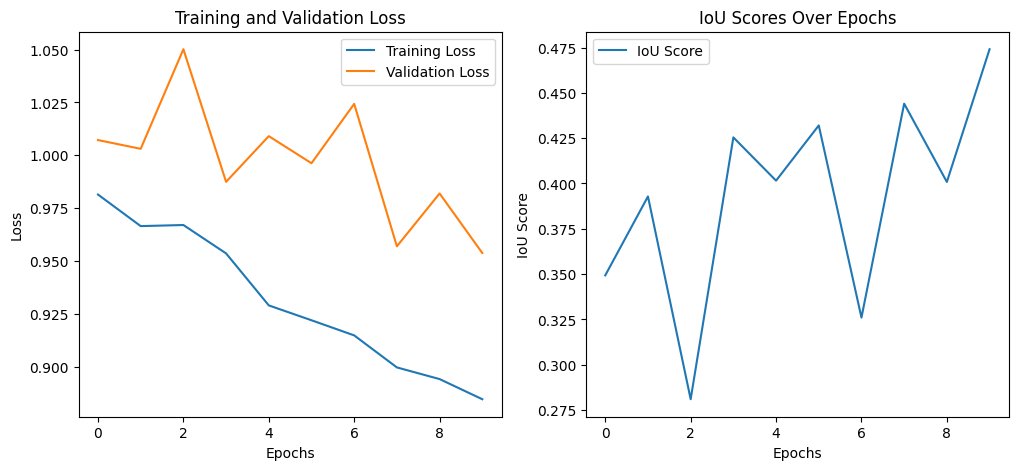

In [56]:
# plot the training  loss or other metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot IoU scores
plt.subplot(1, 2, 2)
plt.plot(iou_scores, label='IoU Score')
plt.title('IoU Scores Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('IoU Score')
plt.legend()

plt.show()


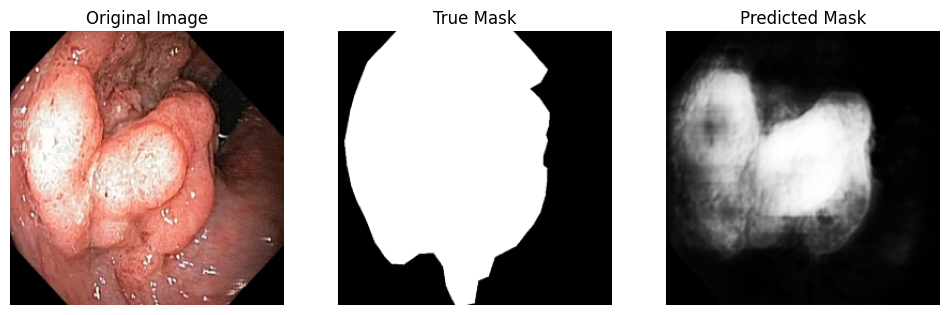

In [65]:
# Plot a sample image and its prediction
index = 1 # You can change the index

model.eval()

sample_image = X_test[index]
sample_mask = y_test[index]

sample_image_tensor = torch.from_numpy(sample_image).unsqueeze(0).permute(0, 3, 1, 2).to(device).float()

with torch.no_grad():
    output = model(sample_image_tensor)
    output = torch.sigmoid(output)

predicted_mask = output.squeeze()  # Remove batch dimension

# Ensure the output is now a 2D array
if predicted_mask.ndim > 2:
    raise ValueError(f"Unexpected number of dimensions: {predicted_mask.ndim}. Expected a 2D array.")

# Convert to numpy for plotting
predicted_mask = predicted_mask.cpu().numpy()

# Plotting
plt.figure(figsize=(12, 4))

# Plot original image
plt.subplot(1, 3, 1)
plt.imshow(sample_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Plot true mask
plt.subplot(1, 3, 2)
plt.imshow(sample_mask, cmap='gray')
plt.title('True Mask')
plt.axis('off')

# Plot predicted mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.show()


# Observations and Results
 Note down the observations and results  here

### Hyperparameters

- Model Architecture: U-Net
- Number of Channels (n_channels): 3 (for RGB images)
- Number of Classes (n_classes): 1 (for binary segmentation)
- Batch Size: 8
- Learning Rate: 1e-3
- Number of Epochs: 10
- Loss Function: Combination of Binary Cross-Entropy (BCE) Loss and Dice Loss
- λ (Lambda) for Dice Loss: 1
- Optimizer: Adam

### Observations and Results

- Avg Train Loss - 0.8847499442100525
- Avg Val loss - 0.953849732875824
- Avg IOU Score - 0.4741

### Reason for Using Binary Cross-Entropy Loss

- Each pixel is classified as either foreground or background, fitting the binary classification framework.
- While BCE Loss focuses on individual pixel classification accuracy, Dice Loss emphasizes the overlap between the predicted and actual segmentation. This combination is particularly beneficial in medical imaging, where capturing the shape and contour of regions is as important as pixel-wise accuracy.

# Vision Transformers 

We have provided you with the a code for a simple vision transformer.
You can call this as follows: 

```python
model = SegmentViT(image_size=256, patch_size=32, in_channels=3, out_channels=1,
 embed_size=1024,num_blocks=6, num_heads=16,dropout).to(device)
```

In [67]:
model = SegmentViT(image_size=256, patch_size=32, in_channels=3, out_channels=1,
                   embed_size=1024, num_blocks=6, num_heads=16, dropout=0.1).to(device)

criterion_bce = torch.nn.BCELoss()
criterion_dice = smp.losses.DiceLoss('binary')
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [68]:
# The training loop to train the model
train_losses = []
val_losses = []
iou_scores = []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0

    # Training
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        outputs = torch.sigmoid(outputs)  # Apply sigmoid once
        loss_bce = criterion_bce(outputs, masks)
        loss_dice = criterion_dice(outputs, masks)
        loss = loss_bce + LAMBDA_DICE * loss_dice
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    val_iou = []

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            outputs = torch.sigmoid(outputs)  # Apply sigmoid once

            loss_bce = criterion_bce(outputs, masks)
            loss_dice = criterion_dice(outputs, masks)
            loss = loss_bce + LAMBDA_DICE * loss_dice
            val_loss += loss.item()

            # Calculate IoU
            iou = iou_metric(outputs, masks)
            val_iou.extend(iou)

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    avg_iou = sum(val_iou) / len(val_iou)

    # Store metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    iou_scores.append(avg_iou)

In [69]:
avg_train_loss = train_loss / len(train_loader)
avg_val_loss = val_loss / len(val_loader)
avg_iou = sum(val_iou) / len(val_iou) if val_iou else 0  # Adding a check if val_iou is empty

print(avg_train_loss, avg_val_loss, avg_iou)

1.5729022963841757 1.427293620109558 tensor([0.0916])


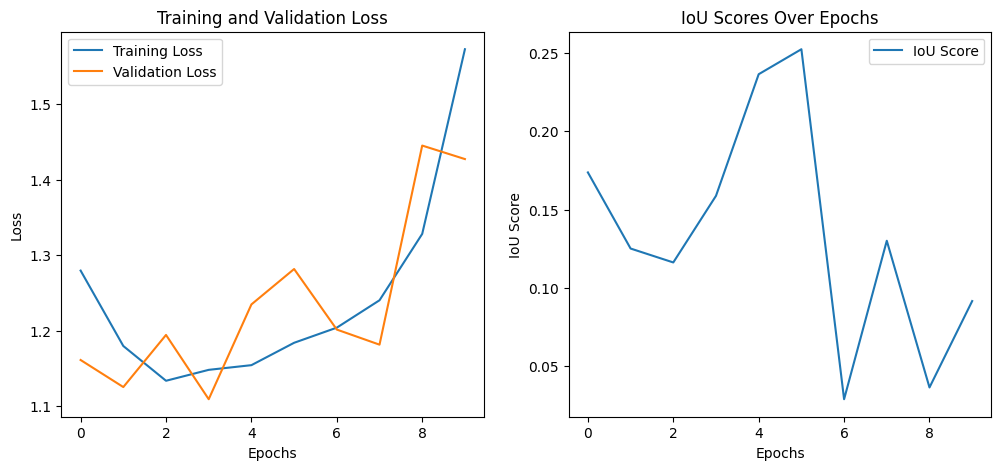

In [70]:
# plot the training  loss or other metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot IoU scores
plt.subplot(1, 2, 2)
plt.plot(iou_scores, label='IoU Score')
plt.title('IoU Scores Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('IoU Score')
plt.legend()

plt.show()

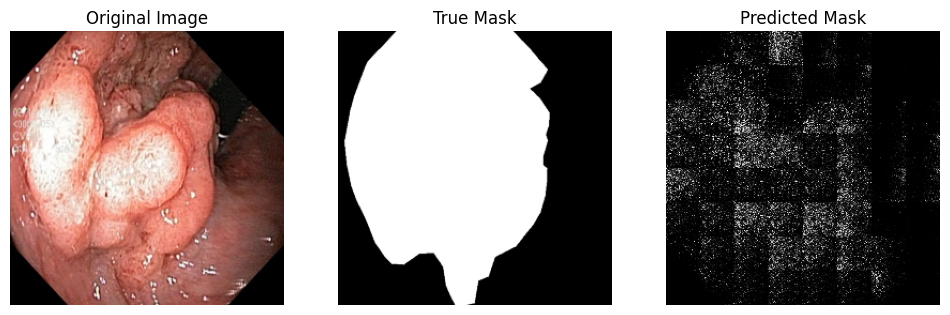

In [71]:
# Plot a sample image and its prediction
index = 1 # You can change the index

model.eval()

sample_image = X_test[index]
sample_mask = y_test[index]

sample_image_tensor = torch.from_numpy(sample_image).unsqueeze(0).permute(0, 3, 1, 2).to(device).float()

with torch.no_grad():
    output = model(sample_image_tensor)
    output = torch.sigmoid(output)

predicted_mask = output.squeeze()  # Remove batch dimension

# Ensure the output is now a 2D array
if predicted_mask.ndim > 2:
    raise ValueError(f"Unexpected number of dimensions: {predicted_mask.ndim}. Expected a 2D array.")

# Convert to numpy for plotting
predicted_mask = predicted_mask.cpu().numpy()

# Plotting
plt.figure(figsize=(12, 4))

# Plot original image
plt.subplot(1, 3, 1)
plt.imshow(sample_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Plot true mask
plt.subplot(1, 3, 2)
plt.imshow(sample_mask, cmap='gray')
plt.title('True Mask')
plt.axis('off')

# Plot predicted mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.show()


# ViT Observations and Results
 Note down the observations and results  here

### Hyperparameters

- Model Architecture: SegmentViT
- Image Size: 256x256
- Patch Size: 32
- Input Channels (in_channels): 3 (RGB Images)
- Output Channels (out_channels): 1 (Binary Segmentation)
- Embedding Size: 1024
- Number of Blocks: 6
- Number of Attention Heads: 16
- Dropout Rate: 0.1
- Batch Size: 8
- Learning Rate: 1e-3
- Number of Epochs: 10
- Loss Function: Combination of Binary Cross-Entropy (BCE) Loss and Dice Loss
- λ (Lambda) for Dice Loss: 1
- Optimizer: Adam

### Observations and Results

- Avg Train Loss - 1.5729022963841757
- Avg Val loss - 1.427293620109558
- Avg IOU Score - 0.0916


### Comparison

- Average Training Loss and Average Validation Loss
    - U-Net values are lower than those reported for the Segment ViT which means the U-Net model is fitting the data more effectively. 
    - The training loss is slightly lower than the validation loss in U-Net indicating good generalization without significant overfitting.

- Average IoU Score
    - An IoU score of approximately 0.4741 in U-Net is considerably higher than what was achieved with the Segment ViT
    - U-Net model has a moderately good performance in capturing the relevant features and segmenting the images.

